# Black-Scholes in Python

## Theoretical basis

### Assumptions

Recall that the Black-Scholes model consists of the following assumptions:

1. The SDE for the Stock price $S(t)$ is a lognormal SDE:
$$
dS = S \left( \mu \, dt + \sigma \, dW \right)
$$
where $\mu$ is a constant drift and $\sigma$ is a constant volatility. Here $W$ is a Wiener process. (Recall that the drift does not enter the BS model.)

2. When the option is European, with the following payoffs for a European Call or Put option respectively:
$$
C = \max(S_T - K, 0) \; , \qquad P = \max(K - S_T, 0)
$$
where $T$ is the delivery time, $S_T$ is the stock price at delivery time and $K$ is the strike price at strike time $t < T$. 

3. The risk-free rate $r$ and the volatility $\sigma$ are known. Note that the risk-free rate can be a function of time.

4. There are no transaction costs. 

5. Delta hedging is done continuously. 

6. There are no arbitrage opportunities and hence, thanks to the First Fundamental Theorem of Mathematical Finance, there is a martingale measure $\mathbb{Q}$ for pricing the option, and viceversa).

### Black-Scholes equation and general solution

The Black-Scholes equation is a Reaction-Convection-Diffusion backwards parabolic linear PDE for the value $V(S(t),t)$ of an option and takes the following form:
$$
\frac{\partial V }{\partial t} + r\, S\, \frac{\partial V }{\partial S} +  \frac{\sigma^2}{2} \, S^2 \, \frac{\partial^2 V }{\partial S^2} - r\, V = 0
$$
This PDE can be derived by considering a portfolio $\Pi = V(S(t),t) - \Delta \, S(t)$, applying Ito's Lemma and hedging by setting $\Delta = \frac{\partial V }{\partial S}$. Recall that the portfolio obeys a deterministic equation: $d\Pi = r \, \Pi \, dt$.

A solution of the BS PDE can be obtained by using two approaches: the differential-equation approach and the martingale approach. 

Citing **Wilmott, Eq.(8.7)**, the solution for a general payoff function $\text{Payoff}(S)$ is:
$$
V(S,t) = \frac{e^{-r(T-t) }}{\sqrt{2 \pi \sigma^2\, (T-t)}} \int_{0}^{\infty} e^{- \Big(\log\left(\frac{S_t}{S'} \right) + (r-\frac{\sigma^2}{2})(T-t)   \Big)^2  \big/2  \sigma^2\, (T-t) } \; \text{Payoff}(S') \, \frac{dS'}{S'} \, . 
$$
Note that this is nothing but the discounted expectation of the payoff function with respect to the martingale measure $\mathbb{Q}$:
\begin{align*}
V(S(t), t) & = e^{-r(T-t)} \mathbb{E}_{\mathbb{Q}}\left[ \text{Payoff}(S_T) \big| S_t \right] \\
& = e^{-r(T-t)} \int_0^{\infty} f(S_T|S_t)   \text{Payoff}(S_T) \, dS_T \, , 
\end{align*}
where $f(S_T|S_t)$ is the risk-neutral transition probability for the stochastic process $\{S_\tau\}_{\tau \in(t,T)}$ and is a log-normal density function:
$$
f(S_T|S_t) = \frac{1}{S_T \sqrt{2 \pi \sigma^2 (T-t)}} \, e^{- \dfrac{\left[  \log(S_T) - [ \log(S_t) + (r - \frac{\sigma^2}{2})(T-t) ]   \right]^2 }{2 \sigma^2 (T-t)}    } \, . 
$$
We have denoted $S_T = S(T)$ and $S_t = S(t)$ for brevity.


In the following, we denote by $N(x)$ the cumulative distribution function for the standard normal distribution:
$$
N(x) = \frac{1}{\sqrt{2 \pi}} \int_{0}^{x} e^{-\frac{u^2}{2}} \, du \, . 
$$

### Some closed-form solutions


- By considering a __European call option__ (with dividends payment), the above expression simplifies considerably to
$$
C(S,t) := V(S,t)_{\text{Call}} = e^{-D(T-t)} \, S\, N(d_1) - e^{-r(T-t)} \, K\, N(d_2)
$$
where
\begin{align*}
d_1 & = \frac{ \log(S/K) + (r-D + \frac{\sigma^2}{2}) (T-t)      }{ \sqrt{\sigma^2 (T-t)}  } \, \\
d_2 & = \frac{ \log(S/K) + (r-D - \frac{\sigma^2}{2}) (T-t)      }{ \sqrt{\sigma^2 (T-t)}  } = d_1 - \sqrt{\sigma^2 (T-t)} \, . 
\end{align*}

- By considering a __European put option__ (with dividends payment $D$), value becomes
$$
P(S,t) := V(S,t)_{\text{Put}} = - e^{-D(T-t)} \, S\, N( - d_1) + e^{-r(T-t)} \, K\, N(-d_2)
$$
Note that $V(S,t)_{\text{Put}(d_1,d_2)} = - V(S,t)_{\text{Call}(-d_1, -d_2)}$.

- If we consider a __Binary call option__, whose payoff is $\theta(S - K)$ where $\theta$ is the Heavisde function, we get
$$
V(S,t)_{\text{Binary Call}} = e^{-r(T-t)} \, N(d_2) \, .
$$

- If we consider a __Binary put option__, whose payoff is $\theta(K - S)$, we get
$$
V(S,t)_{\text{Binary Put}} = e^{-r(T-t)} \left(1- N(d_2) \right) \, . 
$$

It is important to note that the Put-Call Parity holds (in absence of arbitrage):
$$
\text{Call} - \text{Put} = e^{-D(T-t)}\, S - e^{-r(T-t)} \, K\, . 
$$

## Python implementation & visualization of European Call/Put Option

In [157]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


class BS_Pricer:
    '''
    Implements the Black-Scholes pricing of Europen Call/Put option,
    together with some Greeks.
    '''
    def __init__(self, S, K, T, r, sigma, t=0, D=0):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.t = t
        self.D = D

    @staticmethod # A static method doesn't receive any reference argument whether it is called by an instance of a class or by the class itself
    def N(x): # defined the function N(x) for simplcity 
        return norm.cdf(x)
    
    @staticmethod
    def Np(x):
        return (1/ (np.sqrt(2*np.pi)) ) * np.exp(- x**2/2) 
    
    def d1(self): # defined the method for d1 for simplcity
        return ( np.log( self.S/self.K ) + ( self.r - self.D + self.sigma**2/2 ) * (self.T-self.t) )/( self.sigma * np.sqrt(self.T-self.t) )
    
    def d2(self): # defined the method for d2 for simplcity
        return self.d1() - self.sigma * np.sqrt(self.T-self.t)

    
    @property
    def show_params(self):
        '''Shows the parameters'''
        return {'S': self.S, 'K': self.K, 'T': self.T,'r': self.r, 'sigma': self.sigma, 't':self.t, 'D': self.D}
    

    def euro_call(self):
        '''Return the value of an European call option'''
        return np.exp(-self.D * (self.T-self.t) ) * self.S * self.N(self.d1() )  \
            -  np.exp(-self.r * (self.T-self.t) ) * self.K * self.N(self.d2() )
    
    def euro_put(self):
        '''Return the value of an European put option'''
        return - np.exp(-self.D * (self.T-self.t)) * self.S * self.N(- self.d1() )  \
            + np.exp(-self.r * (self.T-self.t)) * self.K * self.N(- self.d2() )
    

    # Some greeks

    def delta_call(self):
        return np.exp(-self.D * (self.T-self.t)) * self.N(self.d1())
    
    def delta_put(self):
        return np.exp(-self.D * (self.T-self.t)) * ( self.N(self.d1()) -1)
    
    def gamma(self):
        return ( np.exp(-self.D * (self.T-self.t)) *  self.Np(self.d1() )  )/(  self.sigma * self.S * np.sqrt(self.T - self.t)  )
    
    def vega(self):
        return  np.exp(-self.D * (self.T-self.t)) * self.S   * np.sqrt(self.T - self.t) * self.Np(self.d1() )    

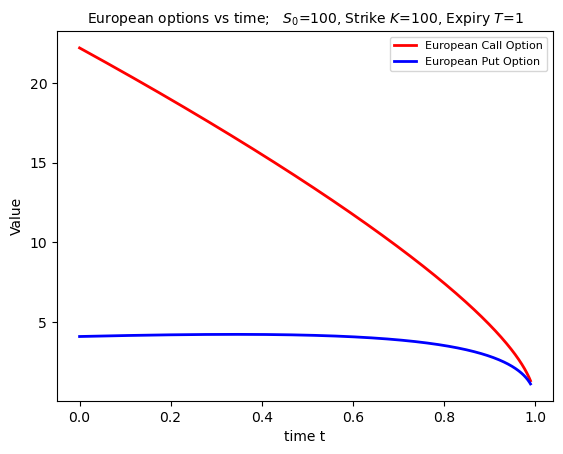

In [132]:
S = 100
K = 100
r = 0.2
T = 1
sigma = 0.3

tt = np.linspace(0,T - 0.01,1000)
y_call_time = []
y_put_time = []
for s in tt:
    y_call_time.append(BS_Pricer(S, K, T, r, sigma, t=s, D=0).euro_call())
    y_put_time.append(BS_Pricer(S, K, T, r, sigma, t=s, D=0).euro_put())

# plt.figure(figsize = (12, 8))
plt.plot(tt, y_call_time, color = "red", linewidth = 2, label = "European Call Option")
plt.plot(tt, y_put_time, color = "blue", linewidth = 2, label = "European Put Option")
plt.title(f"European options vs time;   $S_0$={S}, Strike $K$={K}, Expiry $T$={T}", fontsize = 10)
plt.xlabel("time t")
plt.ylabel("Value")
plt.legend(fontsize = 8)
plt.show()

/var/folders/pf/84d626r53yv3gdzm94b6bmnc0000gn/T/ipykernel_2254/590463897.py:26: RuntimeWarning: divide by zero encountered in log
  return ( np.log( self.S/self.K ) + ( self.r - self.D + self.sigma**2/2 ) * (self.T-self.t) )/( self.sigma * np.sqrt(self.T-self.t) )


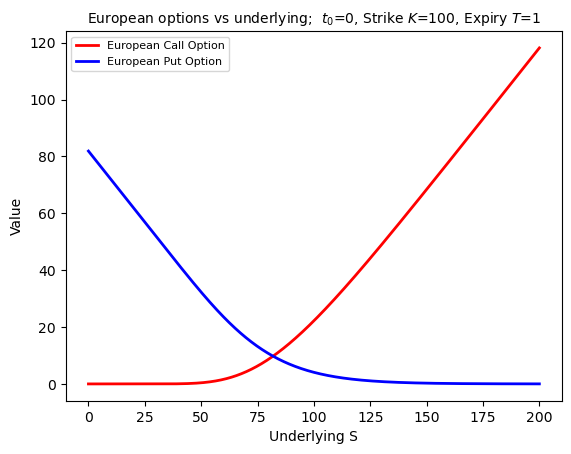

In [133]:
# S = 100
Smax = 200
K = 100
r = 0.2
T = 1
sigma = 0.3

SS = np.linspace(0,Smax,1000)
y_call_underlying = []
y_put_underlying = []
for s in SS:
    y_call_underlying.append(BS_Pricer(s, K, T, r, sigma, t=0, D=0).euro_call())
    y_put_underlying.append(BS_Pricer(s, K, T, r, sigma, t=0, D=0).euro_put())

# plt.figure(figsize = (12, 8))
plt.plot(SS, y_call_underlying, color = "red", linewidth = 2, label = "European Call Option")
plt.plot(SS, y_put_underlying, color = "blue", linewidth = 2, label = "European Put Option")
plt.title(f"European options vs underlying;  $t_0$={0}, Strike $K$={K}, Expiry $T$={T}", fontsize = 10)
plt.xlabel("Underlying S")
plt.ylabel("Value")
plt.legend(fontsize = 8)
plt.show()

In [161]:
# a quick check for put-call parity:
S = 100
K = 100
r = 0.2
T = 1
D = 0
t = 0
sigma = 0.3
print(BS_Pricer(S, K, T, r, sigma, t=0, D=0).euro_call()-BS_Pricer(S, K, T, r, sigma, t=0, D=0).euro_put())
print(np.exp(-D*(T-t))*S - np.exp(-r*(T-t))*K)

18.126924692201804
18.12692469220181


/var/folders/pf/84d626r53yv3gdzm94b6bmnc0000gn/T/ipykernel_2254/590463897.py:26: RuntimeWarning: divide by zero encountered in log
  return ( np.log( self.S/self.K ) + ( self.r - self.D + self.sigma**2/2 ) * (self.T-self.t) )/( self.sigma * np.sqrt(self.T-self.t) )


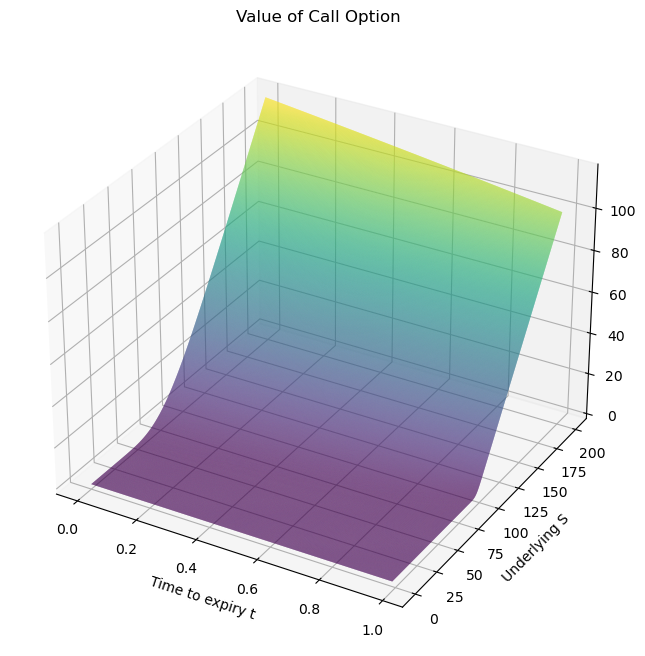

In [150]:
def f(x, y):
   return BS_Pricer(y, K, T, r, sigma, x, D=0).euro_call()

Smax = 200
K = 100
r = 0.2
T = 1
sigma = 0.3

tt = np.linspace(0,T - 0.01,1000)
SS = np.linspace(0,Smax,1000)

x = tt
y = SS

X, Y = np.meshgrid(x, y)
Z = f(X, Y)


fig = plt.figure(figsize = (12, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Time to expiry t')
ax.set_ylabel('Underlying S')
# ax.set_zlabel('Value of Call Option');
ax.set_title('Value of Call Option');

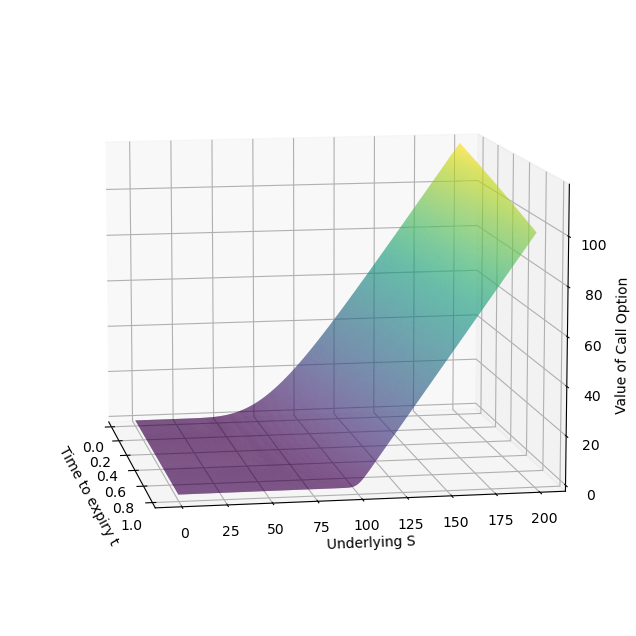

In [149]:
# a different viewpoint for a better visualization
ax.view_init(10, -10) 
fig

## The Greeks

- The __Delta__ of the European Call/Put option
$$
\Delta = \frac{\partial V}{\partial S}
$$
is respectively
$$
\Delta_C = e^{-D(T-t)} N(d_1) \, , \qquad \Delta_P = e^{-D(T-t)} (N(d_1)-1) \, .
$$
Recall that the __Delta__ represents the fraction of the underlying that is necessary to hold in order to delta-hedge, namely to eliminate random fluctuations of the underlying. Note that in the BS model the re-balancing is done continuously and without transaction costs. 

- The __Gamma__ of the European Call/Put option
$$
\Gamma = \frac{\partial^2 V}{\partial S^2}
$$
is 
$$
\Gamma_C = \Gamma_P  = \frac{e^{-D(T-t)} N'(d_1)}{S\sqrt{\sigma^2(T-t)}} \, , \qquad N'(x) = \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}} \, . 
$$
The __Gamma__ informs us on how often the position must be re-hedged in order to mantain a delta-neutral position.

- The __Vega__ (zeta, or kappa) is the sensitivity of the option with respect to the volatility
$$
\kappa = \frac{\partial V}{\partial \sigma} 
$$
and is explicitly given by 
$$
\kappa_C = \kappa_P = S\, \sqrt{T-t}\, e^{-D(T-t)} \, N'(d_1) \, . 
$$


- The __Theta__ is the rate of change of the value with respect to the time:
$$
\Theta = \frac{\partial V}{\partial t} \, .
$$
We leave the derivation as an exercise. 

- __Rho__ is the rate of change of the value with respect to the interest rate:
$$
\rho = \frac{\partial V}{\partial r} \, .
$$
We leave the derivation as an exercise. 





/var/folders/pf/84d626r53yv3gdzm94b6bmnc0000gn/T/ipykernel_2254/1226343979.py:29: RuntimeWarning: divide by zero encountered in log
  return ( np.log( self.S/self.K ) + ( self.r - self.D + self.sigma**2/2 ) * (self.T-self.t) )/( self.sigma * np.sqrt(self.T-self.t) )


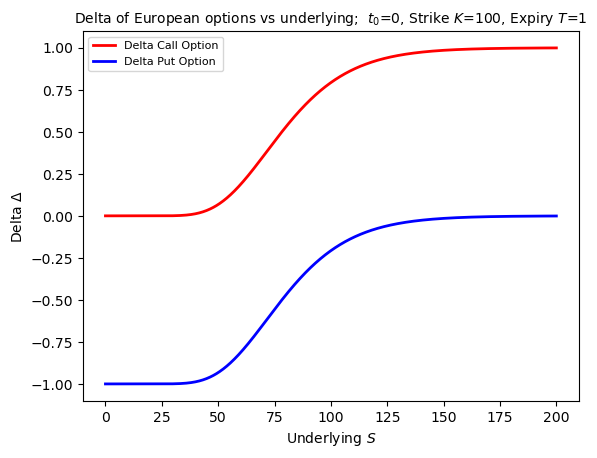

In [155]:
Smax = 200
K = 100
r = 0.2
T = 1
sigma = 0.3

SS = np.linspace(0,Smax,1000)

plt.plot(SS, BS_Pricer(SS, K, T, r, sigma, t=0, D=0).delta_call(), color = "red", linewidth = 2, label = "Delta Call Option")
plt.plot(SS, BS_Pricer(SS, K, T, r, sigma, t=0, D=0).delta_put(), color = "blue", linewidth = 2, label = "Delta Put Option")
plt.title(f"Delta of European options vs underlying;  $t_0$={0}, Strike $K$={K}, Expiry $T$={T}", fontsize = 10)
plt.xlabel("Underlying $S$")
plt.ylabel("Delta $\Delta$")
plt.legend(fontsize = 8)
plt.show()

/var/folders/pf/84d626r53yv3gdzm94b6bmnc0000gn/T/ipykernel_2254/1226343979.py:29: RuntimeWarning: divide by zero encountered in log
  return ( np.log( self.S/self.K ) + ( self.r - self.D + self.sigma**2/2 ) * (self.T-self.t) )/( self.sigma * np.sqrt(self.T-self.t) )
/var/folders/pf/84d626r53yv3gdzm94b6bmnc0000gn/T/ipykernel_2254/1226343979.py:61: RuntimeWarning: invalid value encountered in divide
  return ( np.exp(-self.D * (self.T-self.t)) *  self.Np(self.d1() )  )/(  self.sigma * self.S * np.sqrt(self.T - self.t)  )


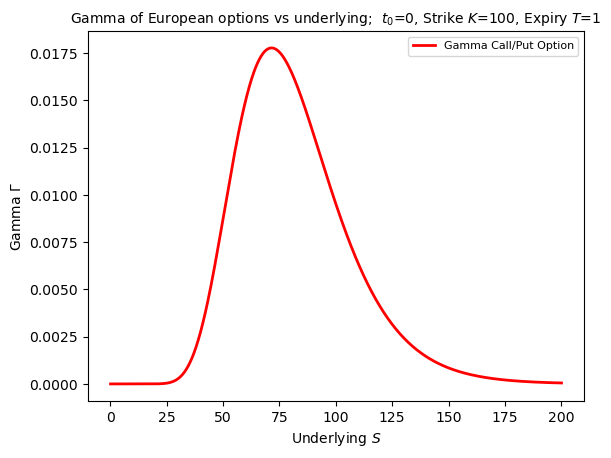

In [156]:
Smax = 200
K = 100
r = 0.2
T = 1
sigma = 0.3

SS = np.linspace(0,Smax,1000)

plt.plot(SS, BS_Pricer(SS, K, T, r, sigma, t=0, D=0).gamma(), color = "red", linewidth = 2, label = "Gamma Call/Put Option")
plt.title(f"Gamma of European options vs underlying;  $t_0$={0}, Strike $K$={K}, Expiry $T$={T}", fontsize = 10)
plt.xlabel("Underlying $S$")
plt.ylabel("Gamma $\Gamma$")
plt.legend(fontsize = 8)
plt.show()

/var/folders/pf/84d626r53yv3gdzm94b6bmnc0000gn/T/ipykernel_2254/3583427382.py:30: RuntimeWarning: divide by zero encountered in log
  return ( np.log( self.S/self.K ) + ( self.r - self.D + self.sigma**2/2 ) * (self.T-self.t) )/( self.sigma * np.sqrt(self.T-self.t) )


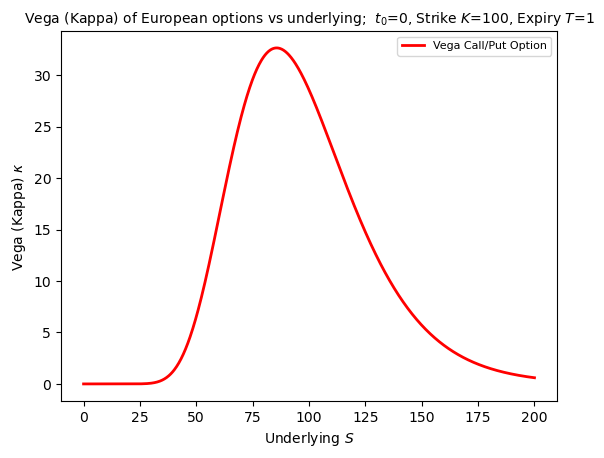

In [158]:
Smax = 200
K = 100
r = 0.2
T = 1
sigma = 0.3

SS = np.linspace(0,Smax,1000)

plt.plot(SS, BS_Pricer(SS, K, T, r, sigma, t=0, D=0).vega(), color = "red", linewidth = 2, label = "Vega Call/Put Option")
plt.title(f"Vega (Kappa) of European options vs underlying;  $t_0$={0}, Strike $K$={K}, Expiry $T$={T}", fontsize = 10)
plt.xlabel("Underlying $S$")
plt.ylabel("Vega (Kappa) $\kappa$")
plt.legend(fontsize = 8)
plt.show()

## Limitations of BS and Implied Volatility

Better to follow:
https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee

### Limitations: large volatility issues

Note that the BS model is not reliable for very high volatility. Indeed, the value of the options has a plateau when the volatility increases to high value. This means that the BS model is not reliable for very high volatility. 

Note that the maximum value for the option is the stock value itself!

/var/folders/pf/84d626r53yv3gdzm94b6bmnc0000gn/T/ipykernel_2254/3583427382.py:30: RuntimeWarning: divide by zero encountered in divide
  return ( np.log( self.S/self.K ) + ( self.r - self.D + self.sigma**2/2 ) * (self.T-self.t) )/( self.sigma * np.sqrt(self.T-self.t) )


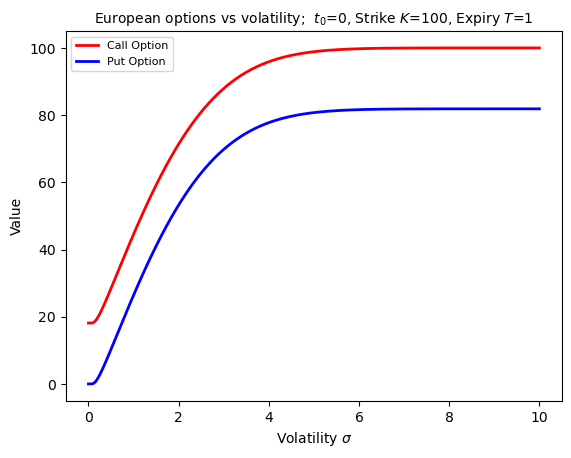

In [163]:
S = 100
K = 100
r = 0.2
T = 1
# sigma = 0.3

sigmass = np.linspace(0,10,1000)

plt.plot(sigmass, BS_Pricer(S, K, T, r, sigmass, t=0, D=0).euro_call(), color = "red", linewidth = 2, label = "Call Option")
plt.plot(sigmass, BS_Pricer(S, K, T, r, sigmass, t=0, D=0).euro_put(), color = "blue", linewidth = 2, label = "Put Option")
plt.title(f"European options vs volatility;  $t_0$={0}, Strike $K$={K}, Expiry $T$={T}", fontsize = 10)
plt.xlabel("Volatility $\sigma$")
plt.ylabel("Value")
plt.legend(fontsize = 8)
plt.show()

### Implied Volatility 

Another issue is the assumption that the voltatily is known, which in general is not the case. 

We will use the Newton-Raphson (NR) algorithm to solve for the volatility of an option, given an _observed_ option value. 

Recall that the NR algorithm, adapted to our case, consists of the following steps:
1. Define the function $f(\sigma) = V_{\text{BS}}(\sigma) - V_{\text{Observed}}$. 
2. Set an initial guess $\sigma_0$.
3. Iterative as follows:
$$
\sigma_{n+1} = \sigma_{n} - \frac{f(\sigma)}{\partial_\sigma f(\sigma)} = \sigma_{n} - \frac{V_{\text{BS}} - V_{\text{Observed}}}{\partial_\sigma V_{\text{BS}}(\sigma)} = \sigma_{n} - \frac{V_{\text{BS}} - V_{\text{Observed}}}{\kappa} \, ,
$$
where we have observed that $V_{\text{BS}}(\sigma) = \kappa$, one of the Greeks computed above.

4. When $|V_{\text{BS}}(\sigma) - V_{\text{Observed}}| < \epsilon$, where $\epsilon$ is a small number (tolerance), return $\sigma_n$. 

In [282]:
def implied_vol(S, K, T, r, V_observed, t, D, call_or_put, max_iter=1000, tolerance = 0.001):
    '''Computes the implied volatility from the following data:
    S = underlying asset price
    K = strike price
    T = expiry date (in years units)
    r = risk-free rate
    V_observed = observed value of the option 
    call_or_put = "call" and "put" for call or put option
    t = time to expiry (t=0 by default)
    D = dividends (D=0 by default)
    max_iter = maximum number of iterations allowed (max_iter=1000 by default)
    tolerance = epsilon in the NR procedure (tolerance=0.001 by default)
    '''

    # initial value for the volatility
    sigma0 = 0.2
    # np.sqrt( (2*np.pi)/(T) ) (V_observed)/(S)  # a convenient way to initialize the volatility

    # run iteration in Newton-Raphson:

    if call_or_put == "call":
        def f(S, K, T, r, sigma0, t=0, D=0):
            return BS_Pricer(S, K, T, r, sigma0, t=0, D=0).euro_call() - V_observed

    elif call_or_put == "put":
        def f(S, K, T, r, sigma0, t=0, D=0):
            return BS_Pricer(S, K, T, r, sigma0, t=0, D=0).euro_put() - V_observed

    else:
        print("Please specify 'call' or 'put'.")

    for i in range(max_iter):
    
        if abs(f(S, K, T, r, sigma0, t=0, D=0)) < tolerance:
            # print("Value of f:",f(S, K, T, r, sigma0, t=0, D=0))
            # print(f"Implied volatility found at the iteration number: {i}")
            # print("Implied volatility is:")
            break
        
        sigma0 = sigma0 - f(S, K, T, r, sigma0, t=0, D=0) / BS_Pricer(S, K, T, r, sigma0, t=0, D=0).vega()

    return sigma0


In [283]:
S = 100
K = 115
r = 0.05
T = 1
V_observed = 100

implied_vol(S, K, T, r, V_observed, t=0, D=0, call_or_put='call', max_iter=1000, tolerance = 0.0001)

9.981476227990404